In [24]:
from datasets import load_dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [42]:
from transformers import BertTokenizer

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
max_length = max(len(tokenizer.encode(text)) for text in dataset['train']['text'])
print(max_length)



/home/FYP/jbong006/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


83


In [43]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], max_length=78, padding='max_length', truncation=True, return_tensors='pt') #pad to max_length specified

tokenized_datasets = dataset.shuffle(seed=42).map(tokenize_function, batched=True) #shuffle() as first few batches only 1

In [44]:
print("Encoded: ")
print(tokenized_datasets['train'][0]["input_ids"])
print(tokenizer.decode(tokenized_datasets['train'][0]["input_ids"]))

print("Attention mask: ")
print(tokenized_datasets['train'][0]["attention_mask"])

Encoded: 
[101, 119, 119, 119, 2399, 1176, 9994, 188, 1643, 11815, 1181, 7091, 4899, 1104, 170, 22572, 4889, 2067, 9285, 1154, 1184, 1110, 4303, 170, 172, 26567, 118, 9297, 18357, 1133, 2191, 118, 3021, 10669, 11826, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS]... plays like somebody spliced random moments of a chris rock routine into what is otherwise a cliche - riddled but self - serious spy thriller. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Attention mask: 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [46]:
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased', 
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Base Model Inference

In [48]:
from sklearn.metrics import accuracy_score
import torch
import tqdm

predictions_1= []
for pred in tqdm.tqdm(tokenized_datasets['test']):
  with torch.no_grad(): # Disable gradient calculation during inference
    outputs = model(**{'input_ids': torch.tensor([pred['input_ids']]), 'attention_mask': torch.tensor([pred['attention_mask']])})
    predict = torch.argmax(outputs.logits, dim=1)
    predictions_1.append(predict.item())
print(accuracy_score(tokenized_datasets['test']['label'], predictions_1))



100%|██████████| 1066/1066 [02:52<00:00,  6.19it/s]

0.5


## Fine Tuning

### LoRA Config

In [49]:
from peft import LoraConfig, get_peft_model, TaskType
lora_config = LoraConfig(
    r=4, #8 # Rank of the LoRA update matrices
    lora_alpha=32, # Scaling factor for the LoRA updates
    target_modules= ["query", "key", "value"],
    lora_dropout=0.1,    
    task_type=TaskType.SEQ_CLS, 
    

   )
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 222,722 || all params: 108,534,532 || trainable%: 0.2052


In [33]:
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(28996, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

### Training Config

In [34]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [35]:
from transformers import Trainer
from transformers import TrainingArguments, DataCollatorWithPadding

training_args = TrainingArguments(output_dir="test_trainer",
        #gradient_accumulation_steps=4, #-- accumulate 4 batch before updating - memory efficient but slow
        num_train_epochs=2,
        learning_rate=0.001,
        per_device_train_batch_size=32,
        # per_device_eval_batch_size=32,
        # weight_decay=0.01,
        logging_steps=10,
        optim="adamw_torch",
        report_to = "none",
        eval_strategy="steps",
        )


trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    #data_collator = DataCollatorWithPadding(tokenizer)

)

In [36]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,0.694200,0.676210,0.579737
20,0.662800,0.546853,0.738274
30,0.497500,0.585106,0.765478
40,0.471300,0.403641,0.827392
50,0.450800,0.439890,0.793621
60,0.477700,0.397992,0.826454
70,0.450400,0.388076,0.830206
80,0.473900,0.423681,0.807692
90,0.395500,0.400746,0.837711
100,0.429400,0.373576,0.838649


TrainOutput(global_step=534, training_loss=0.35525447610165745, metrics={'train_runtime': 162.7073, 'train_samples_per_second': 104.851, 'train_steps_per_second': 3.282, 'total_flos': 685599752036160.0, 'train_loss': 0.35525447610165745, 'epoch': 2.0})

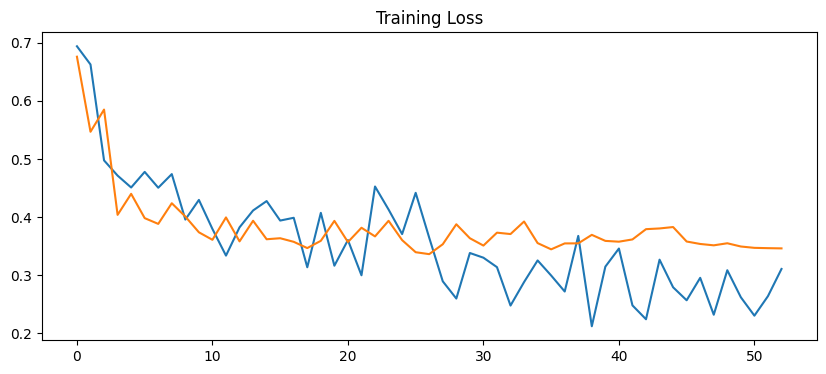

In [37]:
## Save train loss
import matplotlib.pyplot as plt

train_loss = []
eval_loss = []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        train_loss.append(elem['loss'])
    if 'eval_loss' in elem.keys():
        eval_loss.append(elem["eval_loss"])

plt.figure(figsize = (10,4))
plt.plot(train_loss)
plt.plot(eval_loss)
plt.title("Training Loss")
plt.show()

In [ ]:
# peft_model.save_pretrained('lora/lora-bert_v4')


### Inference

In [39]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModelForSequenceClassification  

model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
merged_model_2 = PeftModelForSequenceClassification.from_pretrained(model, "lora/lora-bert_v4") # Load LoRA weights

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/FYP/jbong006/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [50]:
merged_model_2

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(28996, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [40]:
from sklearn.metrics import accuracy_score
import torch
import tqdm

predictions= []
for pred in tqdm.tqdm(tokenized_datasets['test']):
  with torch.no_grad(): 
    outputs = merged_model_2(**{'input_ids': torch.tensor([pred['input_ids']]), 'attention_mask': torch.tensor([pred['attention_mask']])})
    predict = torch.argmax(outputs.logits, dim=1)
    predictions.append(predict.item())




100%|██████████| 1066/1066 [03:01<00:00,  5.88it/s]


In [41]:
print(accuracy_score(tokenized_datasets['test']['label'], predictions))

0.8461538461538461
